In [1]:
import torch

import matplotlib.pyplot as plt
import torchmetrics as tm

from config import *
from stages import *
from train import *
from data.ssa import SSA

from data.util import crop_q_between, split_weekdays_and_weekends

%reload_ext autoreload
%autoreload 2

In [2]:
mse = tm.MeanSquaredError().to(CONFIG.device)
mape = tm.MeanAbsolutePercentageError().to(CONFIG.device)
mat_q = CONFIG.load('mat_q.pt')
CONFIG.alpha = 0.23
mat_q = mat_q[:, mat_q.sum(dim=0) > 0]
normalizing_constants_all = mat_q.max(dim=0)[0]
mat_q /= normalizing_constants_all
mat_q

tensor([[0.0000, 0.0000, 0.0025,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0073, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0150,  ..., 0.0039, 0.0000, 0.0000],
        ...,
        [0.0095, 0.0290, 0.0698,  ..., 0.0000, 0.0463, 0.0000],
        [0.0000, 0.0163, 0.0175,  ..., 0.0000, 0.0256, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [3]:
mat_q.shape

torch.Size([35040, 357])

##### Compare MSE and MAPE losses for different parameter configurations

Pre-train DBN and Train DBN attaching KELM on each epoch

In [17]:
results_wd = {}
results_we = {}

ssa = SSA(4, [2, 2], CONFIG.device)

CONFIG.spectral_threshold = 1440
CONFIG.dbn_hidden_layer_sizes = [80, 80, 80]

gamma = 1
reg_coeff = 1

CONFIG.alpha = 0.779

for gamma in [gamma]:#range(1, 26, 5):
  for reg_coeff in [reg_coeff]:#range(1, 102, 25):
    for P in [40,]:#range(10, 50, 10):
      results_P = {}
      CONFIG.spectral_threshold = P
      for N in [84,]:#range(4, 324, 80):
        CONFIG.dbn_hidden_layer_sizes = [N, N, N]

        mat_c_all, mat_x_all, nonempty, representatives = compress_data(
            mat_q.abs(), CONFIG.read_period, CONFIG.train_period, CONFIG.alpha)
        mat_q_trend_all, mat_q_resid_all = preprocess_data(
            CONFIG.spectral_threshold, mat_c_all)
        mat_q_resid_all = crop_q_between(mat_q_resid_all, CONFIG.read_period,
                                         CONFIG.train_period).real
        mat_c_all = crop_q_between(
            mat_c_all, CONFIG.read_period, CONFIG.train_period)

        print('Representatives: ' + str(representatives.tolist()))
        print(len(representatives))
        for section_index, section_number in enumerate(representatives.tolist()):#[[0, representatives.tolist()[2]]]
          mat_q_trend = mat_q_trend_all[:, section_index][:, None].real
          mat_q_resid = mat_q_resid_all[:, section_index][:, None].real

          norm_const = normalizing_constants_all[section_number].item()

          (_, val_trend_wd_dataloader, _), (_, val_trend_we_dataloader, _) = \
            crop_and_split_mat(mat_q_trend, CONFIG, separate_weekends=False)
          mat_c_wd_datasets, mat_c_we_datasets = split_mat(mat_q_resid, CONFIG)

          del mat_q_resid

          dbn, kelm, val_resid_we_dataloader = train_with_config(
              CONFIG, mat_c_we_datasets, dbn_training_epochs=100, stride=1,
              gamma=gamma, reg_coeff=reg_coeff)
          prefix = f'alpha{CONFIG.alpha}_p{P}_n{N}_sec{section_number}_'\
            .replace('.', '_')
          CONFIG.save(dbn.state_dict(), prefix + 'dbn.pt')
          CONFIG.save(kelm.state_dict(), prefix + 'kelm.pt')

          mse_loss_trend = torch.tensor([0.,]).to(CONFIG.device)
          mse_loss_resid = torch.tensor([0.,]).to(CONFIG.device)
          mse_loss_overall = torch.tensor([0.,]).to(CONFIG.device)
          mse_loss_trend_unnorm = torch.tensor([0.,]).to(CONFIG.device)
          mse_loss_resid_unnorm = torch.tensor([0.,]).to(CONFIG.device)
          mse_loss_overall_unnorm = torch.tensor([0.,]).to(CONFIG.device)

          trend_y = torch.tensor([0.,]).to(CONFIG.device)
          resid_y = torch.tensor([0.,]).to(CONFIG.device)
          overall_y = torch.tensor([0.,]).to(CONFIG.device)

          iter_trend = iter(val_trend_we_dataloader)
          n_samples = 0

          resid = {'y': [], 'pred': []}
          trend = {'y': [], 'pred': []}
          overall = {'y': [], 'pred': []}
          for X_resid, y_resid in val_resid_we_dataloader:
              resid_y += y_resid.item()
              X_trend, y_trend = next(iter_trend)
              trend_y += y_trend.item()
              pred_trend = ssa.forecast(
                  X_trend.squeeze(0).T, 1).sum(0)[-1][None]
              mse_loss_trend += mse(pred_trend, y_trend)
              mse_loss_trend_unnorm += mse(pred_trend * norm_const, y_trend * norm_const)
              trend['y'].append(y_trend.item() * norm_const)
              trend['pred'].append(pred_trend.item() * norm_const)

              pred_resid = dbn(X_resid).squeeze(0)
              pred_resid = kelm(pred_resid).T
              mse_loss_resid += mse(pred_resid, y_resid)
              mse_loss_resid_unnorm += mse(pred_resid * norm_const, y_resid * norm_const)
              resid['y'].append(y_resid.item() * norm_const)
              resid['pred'].append(pred_resid.item() * norm_const)

              pred = pred_trend + pred_resid

              y = y_trend + y_resid
              overall_y += y.item()
              overall['y'].append(y.item() * norm_const)
              overall['pred'].append(pred.item() * norm_const)

              mse_loss_overall += mse(pred, y).item()
              mse_loss_overall_unnorm += mse(pred * norm_const, y * norm_const).item()
              n_samples += 1

          mse_loss_trend /= n_samples
          mse_loss_resid /= n_samples
          mse_loss_overall /= n_samples
          mse_loss_resid_unnorm /= n_samples
          mse_loss_trend_unnorm /= n_samples
          mse_loss_overall_unnorm /= n_samples

          resid_y /= n_samples
          trend_y /= n_samples
          overall_y /= n_samples

          results_P[section_number] = {
              'resid': resid,
              'trend': trend,
              'overall': overall
          }

          print(f'gamma={gamma}, reg_coeff={reg_coeff}, ' +
                f'WE P={CONFIG.spectral_threshold}, ' +
                f'N={CONFIG.dbn_hidden_layer_sizes}, ' +
                f'trend={trend_y.item()}+-{mse_loss_trend.item()}' +
                f'~{mse_loss_trend_unnorm.item()}, ' +
                f'resid={resid_y.item()}+-{mse_loss_resid.item()}' +
                f'~{mse_loss_resid_unnorm.item()}, ' +
                f'overall={overall_y.item()}+-{mse_loss_overall.item()}' +
                f'~{mse_loss_overall_unnorm.item()}')
          del dbn
          del kelm
      results_we[P] = results_P
print(results_we)

Representatives: [0, 26, 30, 33, 46, 49, 53, 56, 62, 63, 65, 70, 77, 84, 94, 103, 104, 111, 122, 127, 131, 139, 144, 150, 153, 160, 165, 170, 179, 187, 202, 203, 211, 216, 227, 243, 246, 247, 253, 255, 260, 263, 271, 272, 280, 297, 300, 306, 314, 325, 326, 342]
52
{40: {}}


In [ ]:
import json
with open('results_we_norm.json', 'w') as file:
  json.dump(results_we, file)

{0: {'resid': {'y': [-2.782067935913801, 2.4754388071596622, 2.8162701800465584, -1.785980723798275, 5.640250034630299, 1.0681051947176456, 7.4754248186945915, -0.15303684398531914, 1.1754871532320976, 0.46165578067302704, 1.7127896659076214, 1.940775029361248, 1.1594785284250975, 1.3820718135684729, 0.6186978612095118, -2.125225765630603, 0.15018649399280548, 0.4394149733707309, -0.26746273040771484, 2.0168897788971663, 2.2790949884802103, -0.4928860254585743, 0.6920056301169097, -0.17088001244701445, -0.08141664817230776, -0.03497176614473574, -1.1180893890559673, -2.8645297698676586, 3.4736464731395245, 19.870010018348694, 1.296074129641056, -2.2750993352383375, -2.8657863568514585, 0.5086339451372623, 2.8407725505530834, -1.8688749801367521, 3.3868392929434776, 0.619627833366394, 0.8431878592818975, 4.070540741086006, 1.3116822112351656, 0.5719131231307983, -0.1489752810448408, 2.143427012488246, 2.4391573760658503, 0.725541296415031, 0.9892175439745188, -0.7818091101944447, -0.596

ValueError: too many values to unpack (expected 3)

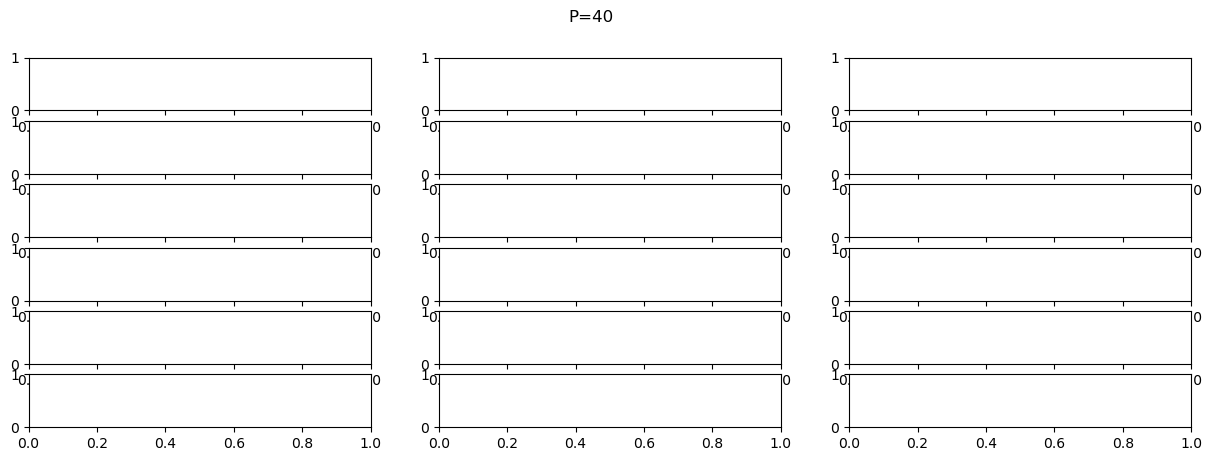

In [6]:
for p, p_data in results_we.items():
    print(p_data)
    fig, axes = plt.subplots(len(p_data), 3)
    fig.set_figwidth(15)
    fig.suptitle(f'P={p}')
    for s, (sec, sec_data) in enumerate(p_data.items()):
        trend_axis, resid_axis, overall_axis = axes
        trend_axis.plot(sec_data['trend']['y'], label='y')
        trend_axis.plot(sec_data['trend']['pred'], label='pred')
        resid_axis.plot(sec_data['resid']['y'], label='y')
        resid_axis.plot(sec_data['resid']['pred'], label='pred')
        overall_axis.plot(sec_data['overall']['y'], label='y')
        overall_axis.plot(sec_data['overall']['pred'], label='pred')
        handles, labels = trend_axis.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center')
    fig.tight_layout()
    fig.show()